<a href="https://colab.research.google.com/github/kxxxda/HandsOnML/blob/main/08_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 설정

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 8.3 PCA

In [2]:
# 3D 데이터셋을 만든다.

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## 8.3.2 주성분

In [3]:
X_centered = X - X.mean(axis = 0)  # PCA를 직접 구현하거나 다른 라이브러리를 사용한다면 먼저 데이터를 원점에 맞춰줘야 한다.
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

## 8.3.3 d차원으로 투영하기

In [6]:
# 첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영한다.

W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

PCA 변환완료

## 8.3.4 사이킷런 사용하기

In [8]:
# 사이킷런의 PCA 모델은 자동으로 데이터를 중앙에 맞춰준다.
# 즉, 데이터셋에서 평균을 빼는 작업도 대신 처리해 준다.
# 아래는 데이터셋의 차원을 2로 줄이는 코드

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

일반적으로 달라지는 것은 일부 축이 반대로 바뀌는 정도(부호만 반대)   
위의 예에서 사이킷런의 PCA는 두 축이 반대로 뒤집힌 것 외에는 SVD 방식을 사용한 것과 통일한 투영 결과를 만든다.

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

In [12]:
# 평면 (PCA 2D 부분공간)에 투영된 3D 포인트를 복원한다.

X3D_inv = pca.inverse_transform(X2D)

In [13]:
# 투영 단계에서 일부 정보를 잃어버리기 때문에 복원된 3D 포인트가 원본 3D 포인트와 완전히 똑같지는 않다.

np.allclose(X3D_inv, X)

False

_False ! 완전히 같지 않다._

In [14]:
# 재구성 오차를 계산한다.

np.mean(np.sum(np.square(X3D_inv - X), axis = 1))

0.010170337792848549

In [15]:
# SVD 방식의 역변환

X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

사이킷런의 PCA 클래스는 자동으로 평균을 뻇던 것을 복원해주기 때문에 두 방식의 재구성 오차가 동일하지는 않다.  
하지만 평균을 빼면 동일한 재구성을 얻을 수 있다.

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [17]:
# PCA 객체를 통해 계산된 주성분을 참조할 수 있다.

pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [18]:
# SVD 방법으로 계산된 처음 두 개의 주성분과 비교해 본다.

Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

축이 뒤집힌 것을 알 수 있다.

## 8.3.5 설명된 분산의 비율

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

이는 데이터셋 분산의 84.2%가 첫 번째 pc를 따라 놓여 있고 14.6%가 두 번째 pc를 따라 놓여 있음을 알려준다.

In [20]:
# 2D로 투영했기 때문에 분산의 1.1%를 잃었다.

1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

In [21]:
# SVD 방식을 사용했을 때 설명된 분산의 비율을 계산하는 방법

np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

이를 그래프로 나타내 본다.  
다음은 3D 화살표를 그리기 위한 유틸리티 클래스

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [23]:
# x와 y의 함수로 평면을 표현한다.

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

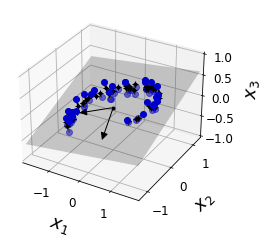

In [24]:
# 3D 데이터셋, 평면 그리고 이 평면으로의 투영을 그린다.

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
        pass
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: 맷플롯립 3.0.0 버전은 버그가 있기 때문에
# 3D 그래프를 잘 출력하지 못합니다.
# https://github.com/matplotlib/matplotlib/issues/12239 를 참조하세요.
# 따라서 최신 버전으로 업그레이드해야 합니다.
# 만약 업그레이드할 수 없다면 3D 그래프를 그리기 전에 다음 코드를 실행하세요:
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.show()

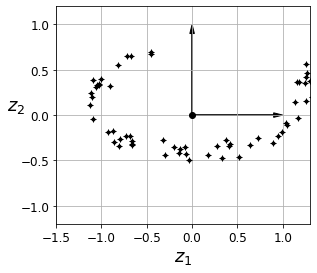

In [25]:
# <그림 8-3. 투영하여 만들어진 새로운 2D 데이터셋> 생성 코드

fig = plt.figure()
ax = fig.add_subplot(111, aspect = 'equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

In [26]:
# <그림 8-4. 스위스롤 데이터셋> 생성 코드

from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 42)

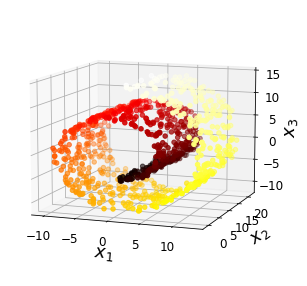

In [27]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

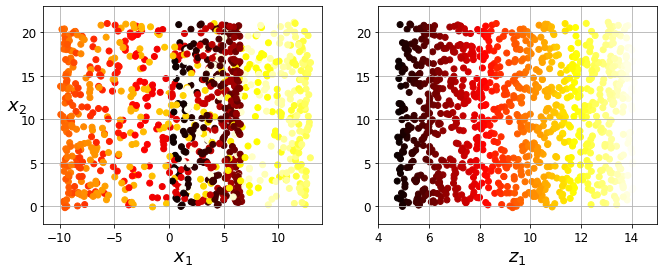

In [28]:

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

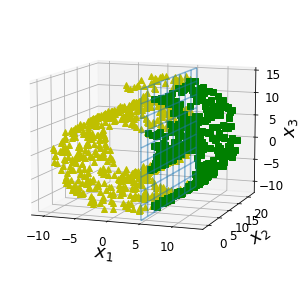

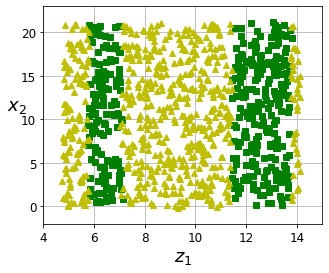

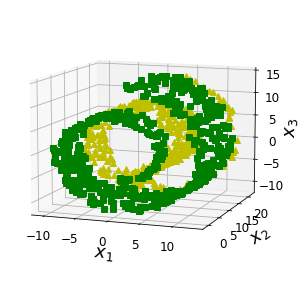

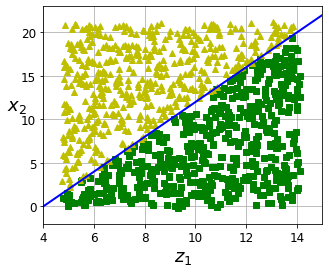

In [29]:
# <그림 8-6. 저차원에서 항상 간단하지 않은 결정 경계> 생성 코드

from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

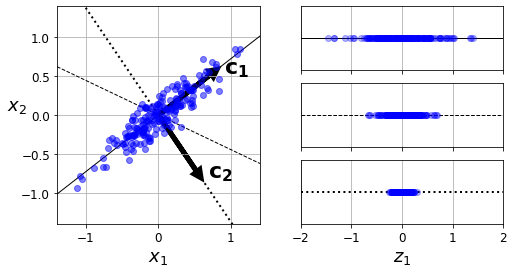

In [30]:
# <그림 8-7. 투영할 부분 공간 선택하기> 생성 코드

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

## 8.3.6 적절한 차원 수 선택하기

In [31]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.target = mnist.target.astype(np.uint8)

In [32]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
# 차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수를 계산한다.

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [34]:
d

154

In [35]:
# n_components =  d로 설정하여 PCA를 다시 실행한다.
# 이때 유지하려는 주성분의 수를 지정하기보다는 보존하려는 분산의 비율로 설정해주는 것이 낫다.

pca =PCA(n_components = 0.95)
X_reduced = pca.fit(X_train)

In [36]:
pca.n_components_

154

In [37]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295707

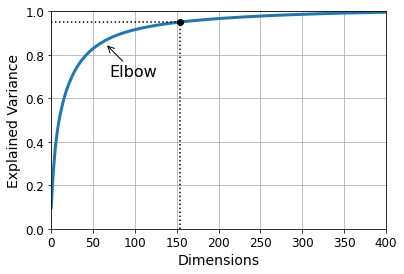

In [38]:
# <그림 8-8. 차원 수에 대한 함수로 나타낸 설명된 분산> 생성 코드

plt.figure(figsize = (6, 4))
plt.plot(cumsum, linewidth = 3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy = (65, 0.85), xytext = (70, 0.7),
                arrowprops = dict(arrowstyle = "->"), fontsize = 16)
plt.grid(True)

plt.show()

## 8.3.7 압축을 위한 PCA

In [39]:
# MNIST 데이터셋을 154차원으로 압축하고 다시 784차원으로 복원해 본다.

pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [40]:
# <그림 8-9. 분산의 95%가 유지된 MNIST 압축> 생성 코드

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

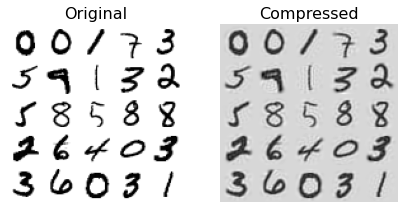

In [41]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

In [42]:
X_reduced_pca = X_reduced

## 8.3.8 랜덤 PCA

In [43]:
rnd_pca = PCA(n_components = 154, svd_solver = "randomized", random_state = 42)
X_reduced = rnd_pca.fit_transform(X_train)

## 8.3.9 점진적 PCA

### 방법1 ) IPCA 알고리즘

In [44]:
# MNIST 데이터셋을 100개의 미니배치로 나누고
# IPCA 알고리즘에 한 번에 하나씩 주입하여 MNIST 데이터셋의 차원을 154개로 줄인다.

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)  # 전체 훈련 세트를 사용하는 fit()메서드가 아니라 partial_fit()메서드를 미니배치마다 호출

X_reduced = inc_pca.transform(X_train)  

_fit하고 -> transform_

In [45]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

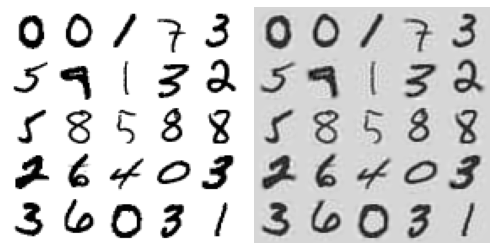

In [46]:
# 압축이 잘 되었는지 확인

plt.figure(figsize = (7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [47]:
# 일반 PCA와 점진적 PCA로 MNIST 데이터를 변환한 결과를 비교해 본다.
# 먼저 평균이 같은지 확인한다.

X_reduced_inc_pca = X_reduced

In [48]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [49]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

평균은 같지만 결과는 완전히 동일하지 않다.  
점진적 PCA는 훌륭한 근사치를 제공하지만 완벽하지는 않다.

### 방법2 ) memmap( )

In [50]:
# memmap() 구조를 만들고 MNIST 데이터를 복사한다.
# 이는 일반적으로 별도의 프로그램에서 먼저 수행된다.

filename = "my_mnist.data"
m, n =  X_train.shape

X_mm = np.memmap(filename, dtype = "float32", mode = "write", shape = (m, n))
X_mm[:] = X_train

In [51]:
# 데이터가 디스크에 저장되었는지 확인하기 위해 memmap() 객체를 삭제한다.

del X_mm

In [52]:
# 다음에 다른 프로그램에서 데이터를 로드하여 훈련에 사용한다.

X_mm = np.memmap(filename, dtype = "float32", mode = "readonly", shape = (m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components = 154, batch_size = batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

### 시간 복잡도

In [53]:
# 주성분 개수를 바꿔가면서 점진적 PCA와 랜덤 PCA에 비해 일반 PCA 시간을 재본다.

rnd_pca = PCA(n_components = 154, svd_solver = "randomized", random_state = 42)
X_reduced = rnd_pca.fit_transform(X_train)

In [54]:
import time
for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components = n_components, svd_solver = "full")
    inc_pca = IncrementalPCA(n_components = n_components, batch_size = 500)
    rnd_pca = PCA(n_components = n_components, random_state = 42, svd_solver = "randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} 초".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 5.8 초
    IncrementalPCA: 34.3 초
    PCA: 1.6 초
n_components = 10
    PCA: 6.2 초
    IncrementalPCA: 36.6 초
    PCA: 1.9 초
n_components = 154
    PCA: 5.4 초
    IncrementalPCA: 48.3 초
    PCA: 3.8 초


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

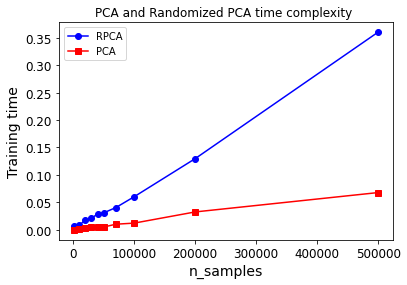

In [55]:
# 데이터셋의 크기(샘플의 수)를 바꿔가면서 일반 PCA와 랜덤 PCA를 비교해 본다.

times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

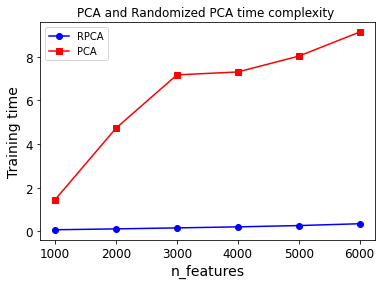

In [56]:
# 특성의 개수를 달리하면서 2000 샘플이 있는 데이터셋에서 성능을 비교해 본다.

times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
plt.show()

# 8.4 커널 PCA

In [57]:
X, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 42)

In [58]:
# KernelPCA를 사용해 RBF 커널로 kPCA를 적용한다.

from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components - 2, kernel = "rbf", gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

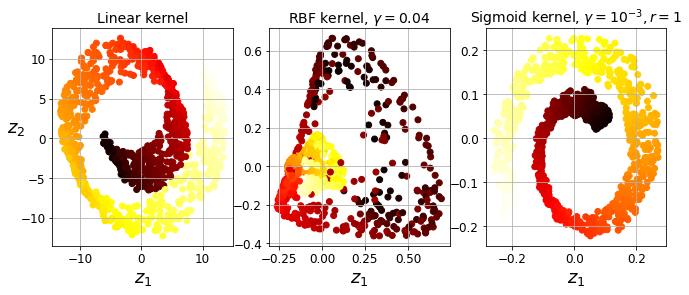

In [59]:
# <그림 8-10. 여러 가지 커널의 kPCA를 사용해 2D로 축소시킨 스위스 롤> 생성 코드


from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

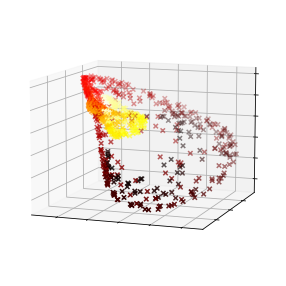

In [60]:
# <그림 8-11. 커널 PCA와 재구성 원상 오차> 생성 코드

plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

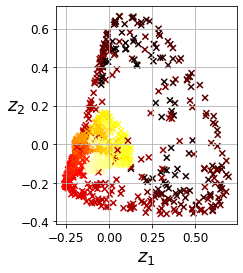

In [61]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

## 8.4.1 커널 선택과 하이퍼파라미터 튜닝

In [62]:
# kPCA를 사용해 2차원으로 축소하고 분류를 위해 로지스틱 회귀를 적용한다.
# 그런 다음 파이프라인 마지막 단계에서 가장 높은 분류 정확도를 얻기 위해 GridSearchCV를 사용해
# 가장 좋은 커널과 gamma 파라미터를 찾는다.

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components = 2)),  # 차원 축소
        ("log_reg", LogisticRegression(solver = "lbfgs"))  # 분류
])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05 ,10),
        "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv = 3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [63]:
# 가장 좋은 커널과 하이퍼파라미터는 best_params_ 변수에 저장된다.

print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [64]:
rbf_pca = KernelPCA(n_components = 2, kernel=  "rbf", gamma = 0.0433,
                    fit_inverse_transform = True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [65]:
# 재구성 원상 오차를 계산한다

from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766146

# 8.5 LLE

In [66]:
# locallyLinearEmbedding을 사용해 스위스 롤을 펼친다.

X, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 41)

In [67]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10, random_state = 42)
X_reduced = lle.fit_transform(X)

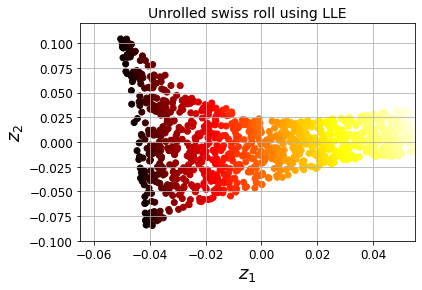

In [68]:
plt.title("Unrolled swiss roll using LLE", fontsize = 14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = t, cmap = plt.cm.hot)
plt.xlabel("$z_1$", fontsize = 18)
plt.ylabel("$z_2$", fontsize = 18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

# 8.6 다른 차원 축소 기법

In [69]:
# 다차원 스케일링 MDS

from sklearn.manifold import MDS

mds = MDS(n_components = 2, random_state = 42)
X_reduced_mds = mds.fit_transform(X)

In [70]:
# Isomap

from sklearn.manifold import Isomap

isomap = Isomap(n_components = 2)
X_reduced_isomap = isomap.fit_transform(X)

In [71]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 42)
X_reduced_tsne = tsne.fit_transform(X)

In [72]:
# 선형 판별 분석

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

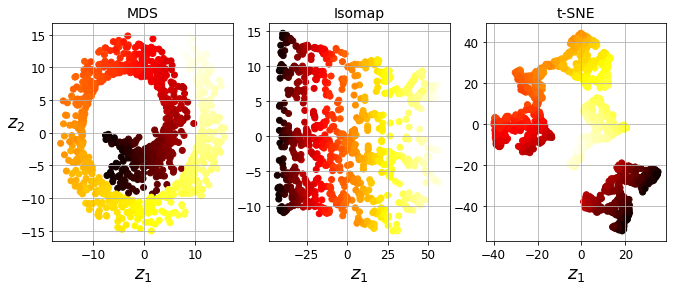

In [73]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize = (11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# 8.7 연습문제

### 9.
MNIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할한다. (처음 60000개는 훈련을 위한 샘플이고 나머지 10000개는 테스트용이다.)  


In [74]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.target = mnist.target.astype(np.uint8)

In [75]:
X_train = mnist["data"][:60000]
y_train = mnist["target"][:60000]

X_test = mnist["data"][60000:]
y_test = mnist["target"][60000:]

이 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가한다.

In [76]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [77]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [78]:
print("훈련 시간 :  {:.2f}s".format(t1-t0))

훈련 시간 :  39.19s


In [79]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

그런 다음 PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소한다.

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X_train)

이 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인한다.  
훈련 속도가 더 빨라지는가?

In [84]:
rnd_clf2 = RandomForestClassifier(n_estimators = 100, random_state = 42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [85]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 84.90s


훈련이 두 배 이상 느려졌다.  
차원 축소는 언제나 훈련 시간을 줄여주지는 못한다.  
데이터셋, 모델, 훈련 알고리즘에 따라 달라진다.  
랜덤 포레스트 분류기 대신 소프트맥스 분류기를 적용하면 PCA를 사용해서 훈련 시간을 3배나 줄일 수 있다.  
우선 먼저 새로운 랜덤 포레스트 분류기의 정밀도를 확인해 본다.

테스트 세트에서 이 분류기를 평가해 본다. 
이전 분류기와 비교해서 어떤가 ?

In [86]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

차원 축소를 했을 때 유용한 정보를 일부 잃었기 때문에 성능이 조금 감소되는 것이 일반적이다.  
그렇지만 이 경우에는 성능 감소가 심각하다. 
PCA가 별로 도움 되지 않았다.  
훈련 시간도 느려지고 성능도 감소했다.  
소프트맥스 회귀를 사용하면 도움이 되는지 확인해 본다. 

In [91]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", random_state = 42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

c:\Users\dahyeon\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [92]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 18.80s


In [93]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

소프트맥스 회귀는 랜덤 포레스트 분류기보다 이 데이터셋에서 훈련하는 데 더 많은 시간이 걸리고 테스트 세트에서의 성능도 더 나쁘다.  
하지만 지금 관심 사항은 아니다.  
PCA가 소프트맥스 회귀에 얼마나 도움이 되는지가 궁금하다.  
축소된 데이터셋에 소프트맥스 회귀 모델을 훈련시켜 본다.

In [94]:
log_clf2 = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", random_state = 42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

c:\Users\dahyeon\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 6.71s


훈련 시간이 빨라졌다.  
모델의 정확도를 확인해 본다.

In [96]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

성능이 조금 감소되었지만 애플리케이션에 따라서 2배 이상의 속도 향상에 대한 댓가로 적절한 것 같다.

### 10.
t-SNE 알고리즘을 사용해 MNIST 데이터셋을 2차원으로 축소시키고 맷플롯립으로 그래프를 그려라.  
이미지의 타깃 클래스마다 10가지 색깔로 나타낸 산점도를 그릴 수 있다.

In [98]:
# 전체 60000개의 이미지에 차원 축소를 하면 매우 오래 시간이 걸리므로 10000개의 이미지만 무작위로 선택하여 사용한다.

np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [99]:
# t-SNE를 사용해 2D 차원을 축소해 그래프로 나타낸다.

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 42)
X_reduced = tsne.fit_transform(X)

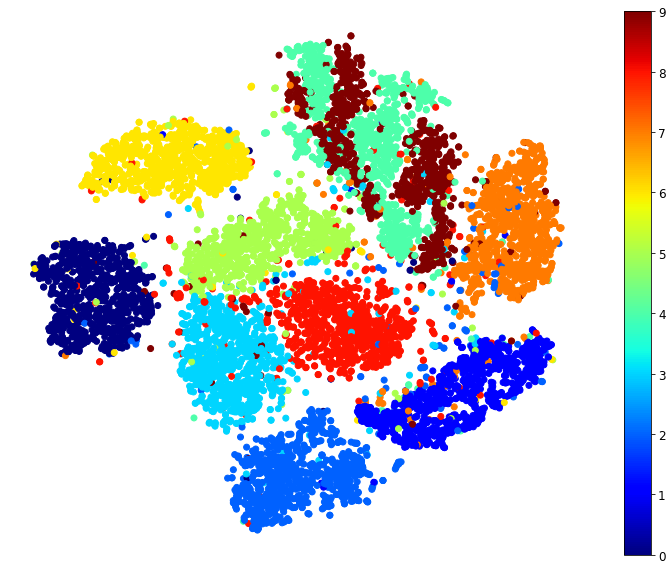

In [100]:
plt.figure(figsize = (13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = y, cmap = "jet")
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
# 많이 겹쳐진 것 같은 숫자 2, 3, 4에 집중해서 본다.

plt.figure(figsize = (9, 9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c = [cmap(digit / 9)])
plt.axis('off')
plt.show()